In [4]:
# Chroma Change Embeddings Analysis
# Analysis of extracted embeddings from chroma_change dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")


Libraries imported successfully!


In [5]:
# Load embeddings and metadata
embeddings_dir = Path("embeddings/chroma_change")
dataset_manifest_path = Path("local_experiments/color_dataset/chroma_change/manifest.json")

# Load dataset manifest for color information
with open(dataset_manifest_path, 'r') as f:
    dataset_manifest = json.load(f)

# Create mapping from index to color metadata
index_to_color = {}
for chain in dataset_manifest['chains']:
    for item in chain['items']:
        idx = str(item['index'])
        index_to_color[idx] = {
            'notation': item['notation'],
            'xyY': item['xyY'],
            'H': item['H'],
            'C': item['C'],
            'V': item['V'],
            'chain_description': chain['description']
        }

print(f"Loaded metadata for {len(index_to_color)} color samples")
print("Sample color data:")
for i in range(1, 6):
    if str(i) in index_to_color:
        print(f"  {i}: {index_to_color[str(i)]['notation']} - {index_to_color[str(i)]['chain_description']}")


Loaded metadata for 32 color samples
Sample color data:
  1: N0 - chain fixed H=N C=0 V=None
  2: N1 - chain fixed H=N C=0 V=None
  3: 2.5R 5/0 - chain fixed H=2.5R C=None V=5
  4: 2.5R 5/2 - chain fixed H=2.5R C=None V=5
  5: 2.5R 5/4 - chain fixed H=2.5R C=None V=5


In [6]:
# Load all embeddings
def load_embeddings(embeddings_dir):
    """Load all embedding files and return organized data"""
    embeddings_data = {
        'lm_pooled_mean': [],
        'vision_pooled_mean': [],
        'visual_token_lens': [],
        'indices': [],
        'metadata': []
    }
    
    # Get all subdirectories (numbered folders)
    subdirs = sorted([d for d in embeddings_dir.iterdir() if d.is_dir() and d.name.isdigit()])
    
    for subdir in subdirs:
        idx = subdir.name
        
        # Load manifest for metadata
        manifest_path = subdir / 'manifest.json'
        if manifest_path.exists():
            with open(manifest_path, 'r') as f:
                manifest = json.load(f)
            embeddings_data['metadata'].append(manifest)
        else:
            embeddings_data['metadata'].append({})
        
        # Load embeddings
        lm_path = subdir / 'lm_pooled_mean.npy'
        vision_path = subdir / 'vision_pooled_mean.npy'
        lens_path = subdir / 'visual_token_lens.npy'
        
        if lm_path.exists():
            lm_emb = np.load(lm_path)
            embeddings_data['lm_pooled_mean'].append(lm_emb.flatten())
        else:
            embeddings_data['lm_pooled_mean'].append(None)
            
        if vision_path.exists():
            vision_emb = np.load(vision_path)
            embeddings_data['vision_pooled_mean'].append(vision_emb.flatten())
        else:
            embeddings_data['vision_pooled_mean'].append(None)
            
        if lens_path.exists():
            lens_emb = np.load(lens_path)
            embeddings_data['visual_token_lens'].append(lens_emb.flatten())
        else:
            embeddings_data['visual_token_lens'].append(None)
            
        embeddings_data['indices'].append(idx)
    
    return embeddings_data

# Load the data
embeddings_data = load_embeddings(embeddings_dir)
print(f"Loaded embeddings for {len(embeddings_data['indices'])} samples")

# Check embedding shapes
for emb_type in ['lm_pooled_mean', 'vision_pooled_mean', 'visual_token_lens']:
    valid_embs = [emb for emb in embeddings_data[emb_type] if emb is not None]
    if valid_embs:
        print(f"{emb_type}: {len(valid_embs)} samples, shape {valid_embs[0].shape}")
    else:
        print(f"{emb_type}: No valid embeddings found")


Loaded embeddings for 32 samples
lm_pooled_mean: 32 samples, shape (3584,)
vision_pooled_mean: 32 samples, shape (3584,)
visual_token_lens: 32 samples, shape (1,)


In [7]:
# Prepare data for analysis
def prepare_embedding_matrix(embeddings_list):
    """Convert list of embeddings to matrix, filtering out None values"""
    valid_embeddings = [emb for emb in embeddings_list if emb is not None]
    if not valid_embeddings:
        return None, []
    
    # Get valid indices
    valid_indices = [i for i, emb in enumerate(embeddings_list) if emb is not None]
    
    # Stack embeddings into matrix
    embedding_matrix = np.vstack(valid_embeddings)
    return embedding_matrix, valid_indices

# Prepare matrices for each embedding type
lm_matrix, lm_valid_indices = prepare_embedding_matrix(embeddings_data['lm_pooled_mean'])
vision_matrix, vision_valid_indices = prepare_embedding_matrix(embeddings_data['vision_pooled_mean'])
lens_matrix, lens_valid_indices = prepare_embedding_matrix(embeddings_data['visual_token_lens'])

print("Embedding matrices prepared:")
if lm_matrix is not None:
    print(f"  LM pooled mean: {lm_matrix.shape}")
if vision_matrix is not None:
    print(f"  Vision pooled mean: {vision_matrix.shape}")
if lens_matrix is not None:
    print(f"  Visual token lens: {lens_matrix.shape}")

# Create color metadata for valid samples
def get_color_metadata(valid_indices, embeddings_data, index_to_color):
    """Get color metadata for valid embedding samples"""
    color_metadata = []
    for i, orig_idx in enumerate(valid_indices):
        idx = embeddings_data['indices'][orig_idx]
        if idx in index_to_color:
            color_info = index_to_color[idx].copy()
            color_info['original_index'] = orig_idx
            color_info['embedding_index'] = i
            color_metadata.append(color_info)
        else:
            color_metadata.append({
                'notation': f'Unknown_{idx}',
                'original_index': orig_idx,
                'embedding_index': i
            })
    return color_metadata

lm_color_meta = get_color_metadata(lm_valid_indices, embeddings_data, index_to_color)
vision_color_meta = get_color_metadata(vision_valid_indices, embeddings_data, index_to_color)
lens_color_meta = get_color_metadata(lens_valid_indices, embeddings_data, index_to_color)


Embedding matrices prepared:
  LM pooled mean: (32, 3584)
  Vision pooled mean: (32, 3584)
  Visual token lens: (32, 1)


In [10]:
# PCA Analysis for all embedding types
def perform_pca_analysis(embedding_matrix, color_metadata, embedding_name):
    """Perform PCA analysis and return results"""
    if embedding_matrix is None:
        print(f"No data available for {embedding_name}")
        return None
    
    # Standardize the data
    scaler = StandardScaler()
    embedding_matrix_scaled = scaler.fit_transform(embedding_matrix)
    
    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(embedding_matrix_scaled)
    
    # Calculate explained variance ratios
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    # Find number of components for different variance thresholds
    n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
    n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1
    
    print(f"\n=== PCA Analysis for {embedding_name} ===")
    print(f"Original dimensions: {embedding_matrix.shape[1]}")
    print(f"Number of samples: {embedding_matrix.shape[0]}")
    print(f"Components for 90% variance: {n_components_90}")
    print(f"Components for 95% variance: {n_components_95}")
    print(f"Components for 99% variance: {n_components_99}")
    print(f"First 10 components explain {cumulative_variance[9]:.3f} of variance")
    
    return {
        'pca_result': pca_result,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance': cumulative_variance,
        'n_components_95': n_components_95,
        'n_components_99': n_components_99,
        'pca_model': pca,
        'scaler': scaler
    }

# Perform PCA for each embedding type
pca_results = {}
if lm_matrix is not None:
    pca_results['lm'] = perform_pca_analysis(lm_matrix, lm_color_meta, "LM Pooled Mean")
if vision_matrix is not None:
    pca_results['vision'] = perform_pca_analysis(vision_matrix, vision_color_meta, "Vision Pooled Mean")



=== PCA Analysis for LM Pooled Mean ===
Original dimensions: 3584
Number of samples: 32
Components for 90% variance: 5
Components for 95% variance: 7
Components for 99% variance: 11
First 10 components explain 0.986 of variance

=== PCA Analysis for Vision Pooled Mean ===
Original dimensions: 3584
Number of samples: 32
Components for 90% variance: 5
Components for 95% variance: 7
Components for 99% variance: 10
First 10 components explain 0.991 of variance


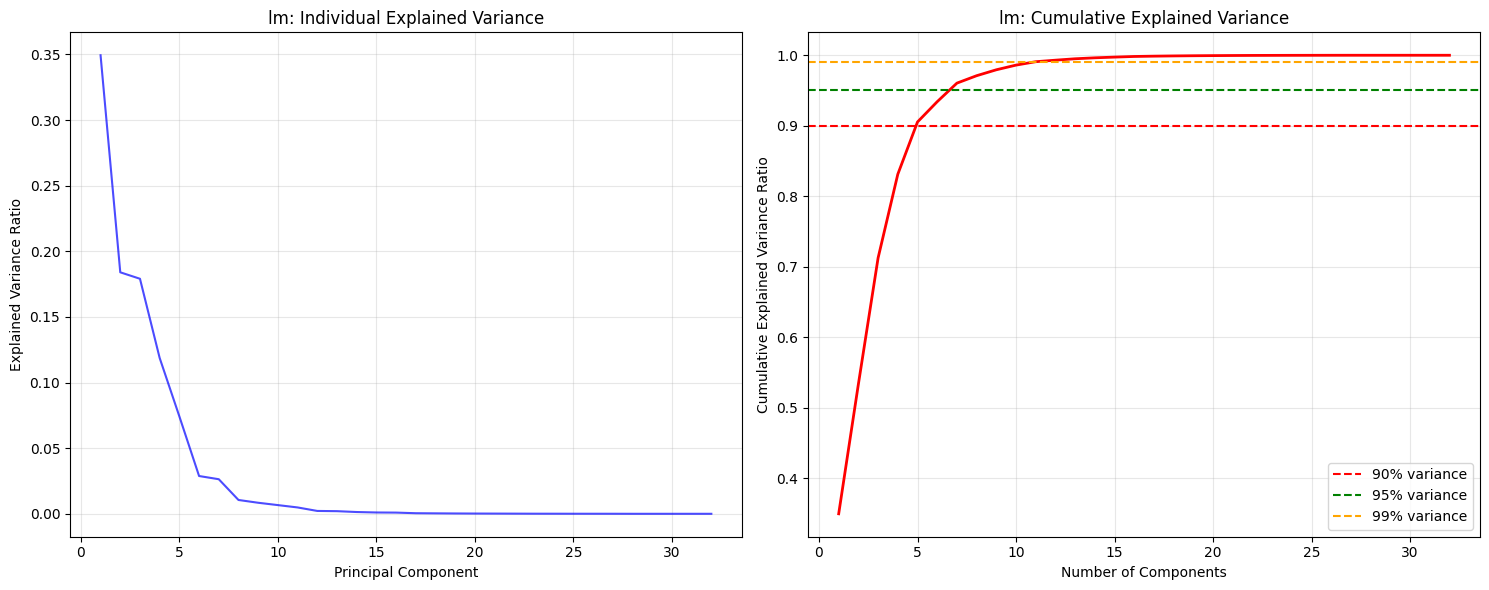

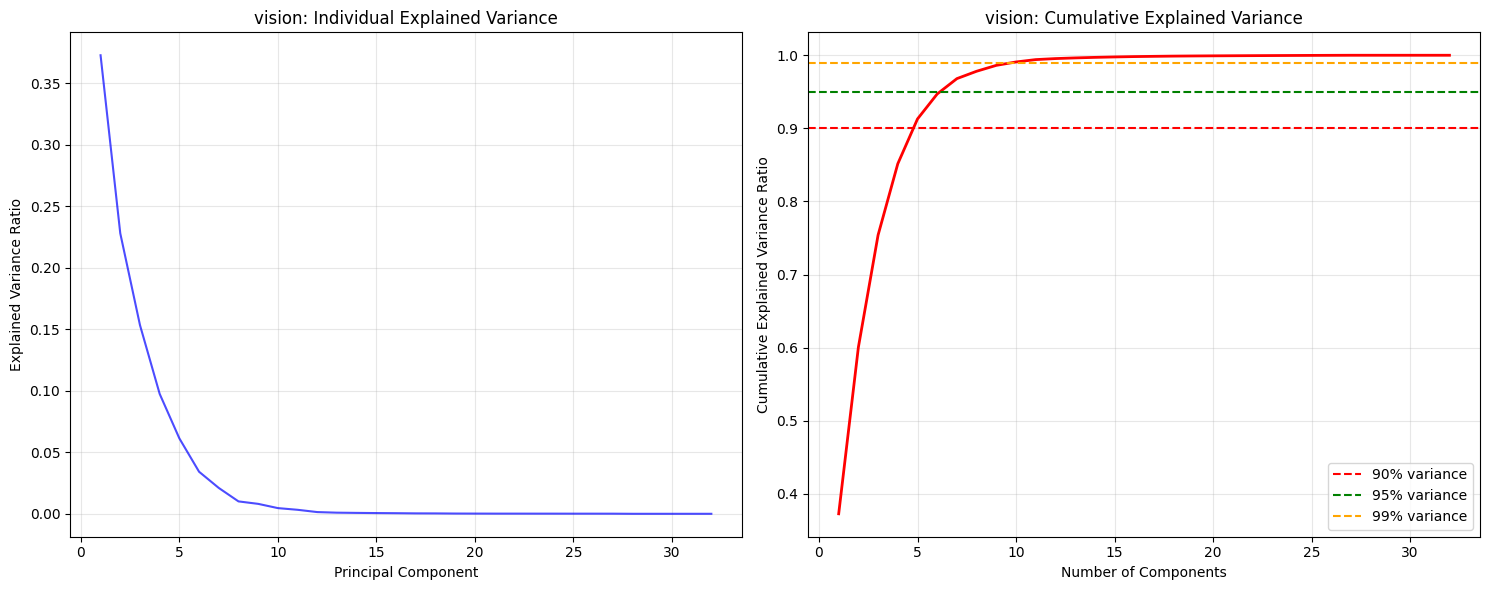

In [12]:

# Visualize PCA results
def plot_pca_variance(pca_results, embedding_name):
    """Plot explained variance for PCA"""
    if embedding_name not in pca_results or pca_results[embedding_name] is None:
        return
    
    result = pca_results[embedding_name]
    explained_var = result['explained_variance_ratio']
    cumulative_var = result['cumulative_variance']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Individual explained variance
    ax1.plot(range(1, min(51, len(explained_var) + 1)), explained_var[:50], 'b-', alpha=0.7)
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title(f'{embedding_name}: Individual Explained Variance')
    ax1.grid(True, alpha=0.3)
    
    # Cumulative explained variance
    ax2.plot(range(1, len(cumulative_var) + 1), cumulative_var, 'r-', linewidth=2)
    ax2.axhline(y=0.90, color='red', linestyle='--', label='90% variance')
    ax2.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
    ax2.axhline(y=0.99, color='orange', linestyle='--', label='99% variance')
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title(f'{embedding_name}: Cumulative Explained Variance')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot PCA variance for all embedding types
for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in pca_results:
        plot_pca_variance(pca_results, emb_type)


In [14]:
# t-SNE Analysis for all embedding types
def perform_tsne_analysis(embedding_matrix, color_metadata, embedding_name, perplexity=30, n_iter=1000):
    """Perform t-SNE analysis and return results"""
    if embedding_matrix is None:
        print(f"No data available for {embedding_name}")
        return None
    
    print(f"\n=== t-SNE Analysis for {embedding_name} ===")
    print(f"Input shape: {embedding_matrix.shape}")
    print(f"Perplexity: {perplexity}")
    
    # Standardize the data
    scaler = StandardScaler()
    embedding_matrix_scaled = scaler.fit_transform(embedding_matrix)
    
    # Perform t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=n_iter, random_state=42, verbose=1)
    tsne_result = tsne.fit_transform(embedding_matrix_scaled)
    
    print(f"t-SNE completed. Final KL divergence: {tsne.kl_divergence_:.3f}")
    
    return {
        'tsne_result': tsne_result,
        'tsne_model': tsne,
        'scaler': scaler
    }

# Perform t-SNE for each embedding type
tsne_results = {}
if lm_matrix is not None:
    tsne_results['lm'] = perform_tsne_analysis(lm_matrix, lm_color_meta, "LM Pooled Mean")
if vision_matrix is not None:
    tsne_results['vision'] = perform_tsne_analysis(vision_matrix, vision_color_meta, "Vision Pooled Mean")



=== t-SNE Analysis for LM Pooled Mean ===
Input shape: (32, 3584)
Perplexity: 30
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 32 samples in 0.001s...
[t-SNE] Computed neighbors for 32 samples in 0.412s...
[t-SNE] Computed conditional probabilities for sample 32 / 32
[t-SNE] Mean sigma: 119.572926
[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.672382
[t-SNE] KL divergence after 1000 iterations: -0.012577
t-SNE completed. Final KL divergence: -0.013

=== t-SNE Analysis for Vision Pooled Mean ===
Input shape: (32, 3584)
Perplexity: 30
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 32 samples in 0.000s...
[t-SNE] Computed neighbors for 32 samples in 0.261s...
[t-SNE] Computed conditional probabilities for sample 32 / 32
[t-SNE] Mean sigma: 115.370627
[t-SNE] KL divergence after 250 iterations with early exaggeration: 36.601051
[t-SNE] KL divergence after 900 iterations: -0.021405
t-SNE completed. Final KL divergence: -0.021


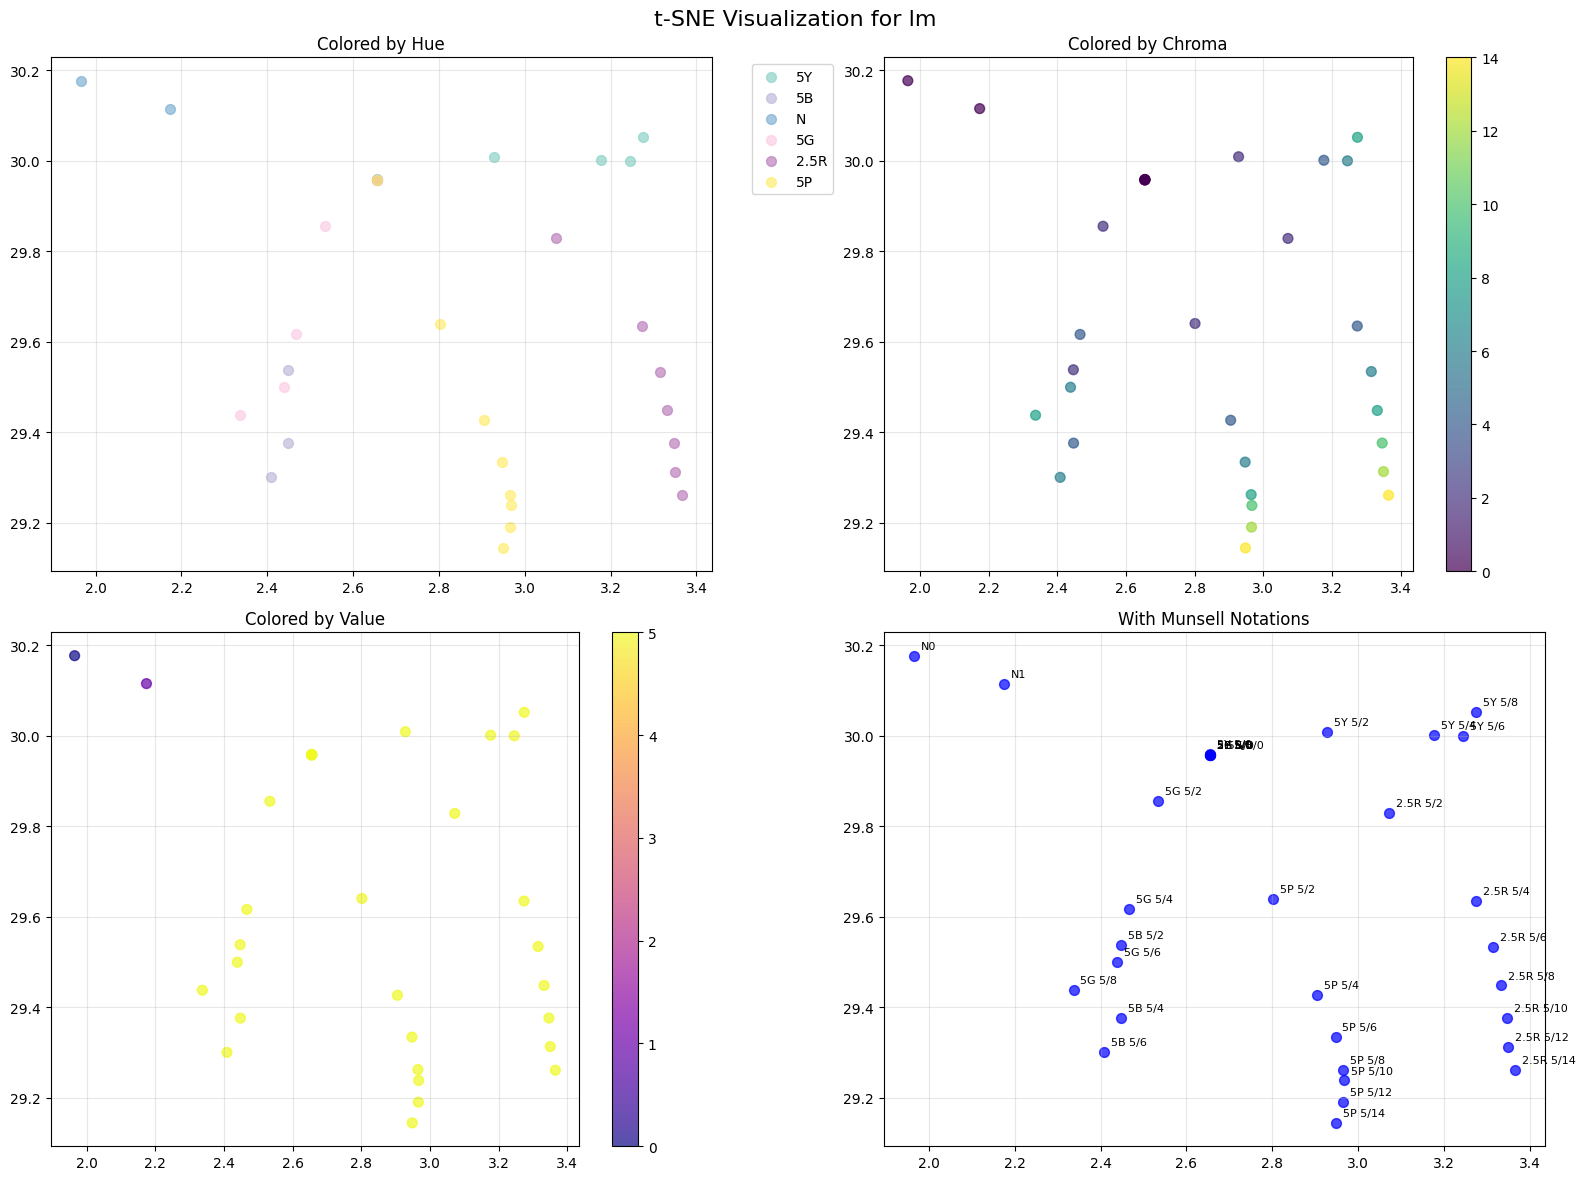

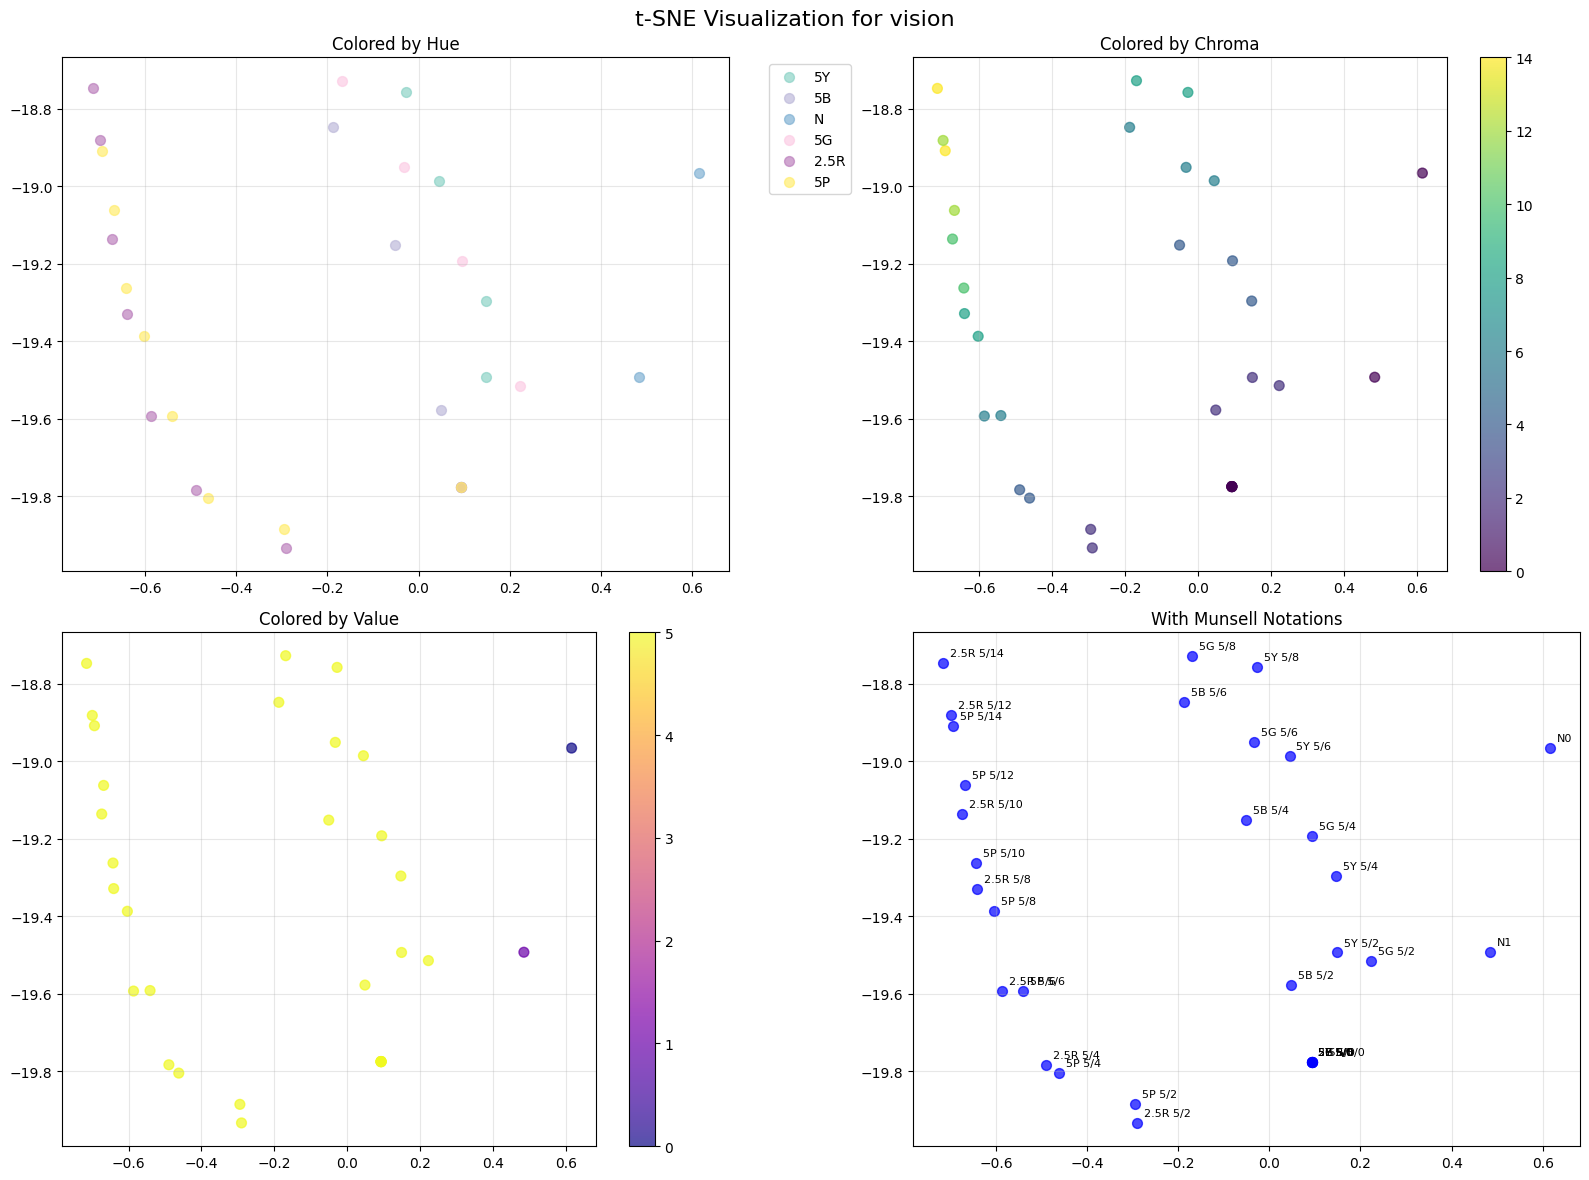

In [15]:
# Visualize t-SNE results with color information
def plot_tsne_results(tsne_results, color_metadata, embedding_name):
    """Plot t-SNE results colored by different color attributes"""
    if embedding_name not in tsne_results or tsne_results[embedding_name] is None:
        return
    
    tsne_result = tsne_results[embedding_name]['tsne_result']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f't-SNE Visualization for {embedding_name}', fontsize=16)
    
    # Extract color information
    hues = [meta.get('H', 'Unknown') for meta in color_metadata]
    chromas = [meta.get('C', 0) for meta in color_metadata]
    values = [meta.get('V', 0) for meta in color_metadata]
    notations = [meta.get('notation', 'Unknown') for meta in color_metadata]
    
    # Plot 1: Colored by Hue
    unique_hues = list(set(hues))
    hue_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_hues)))
    hue_color_map = {hue: hue_colors[i] for i, hue in enumerate(unique_hues)}
    
    for hue in unique_hues:
        mask = [h == hue for h in hues]
        axes[0,0].scatter(tsne_result[mask, 0], tsne_result[mask, 1], 
                         c=[hue_color_map[hue]], label=hue, alpha=0.7, s=50)
    axes[0,0].set_title('Colored by Hue')
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Colored by Chroma
    scatter = axes[0,1].scatter(tsne_result[:, 0], tsne_result[:, 1], 
                               c=chromas, cmap='viridis', alpha=0.7, s=50)
    axes[0,1].set_title('Colored by Chroma')
    plt.colorbar(scatter, ax=axes[0,1])
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Colored by Value
    scatter = axes[1,0].scatter(tsne_result[:, 0], tsne_result[:, 1], 
                               c=values, cmap='plasma', alpha=0.7, s=50)
    axes[1,0].set_title('Colored by Value')
    plt.colorbar(scatter, ax=axes[1,0])
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: All points with notation labels
    axes[1,1].scatter(tsne_result[:, 0], tsne_result[:, 1], 
                     c='blue', alpha=0.7, s=50)
    # Add notation labels
    for i, notation in enumerate(notations):
        axes[1,1].annotate(notation, (tsne_result[i, 0], tsne_result[i, 1]), 
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[1,1].set_title('With Munsell Notations')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot t-SNE results for all embedding types
for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in tsne_results:
        color_meta = {'lm': lm_color_meta, 'vision': vision_color_meta, 'lens': lens_color_meta}[emb_type]
        plot_tsne_results(tsne_results, color_meta, emb_type)


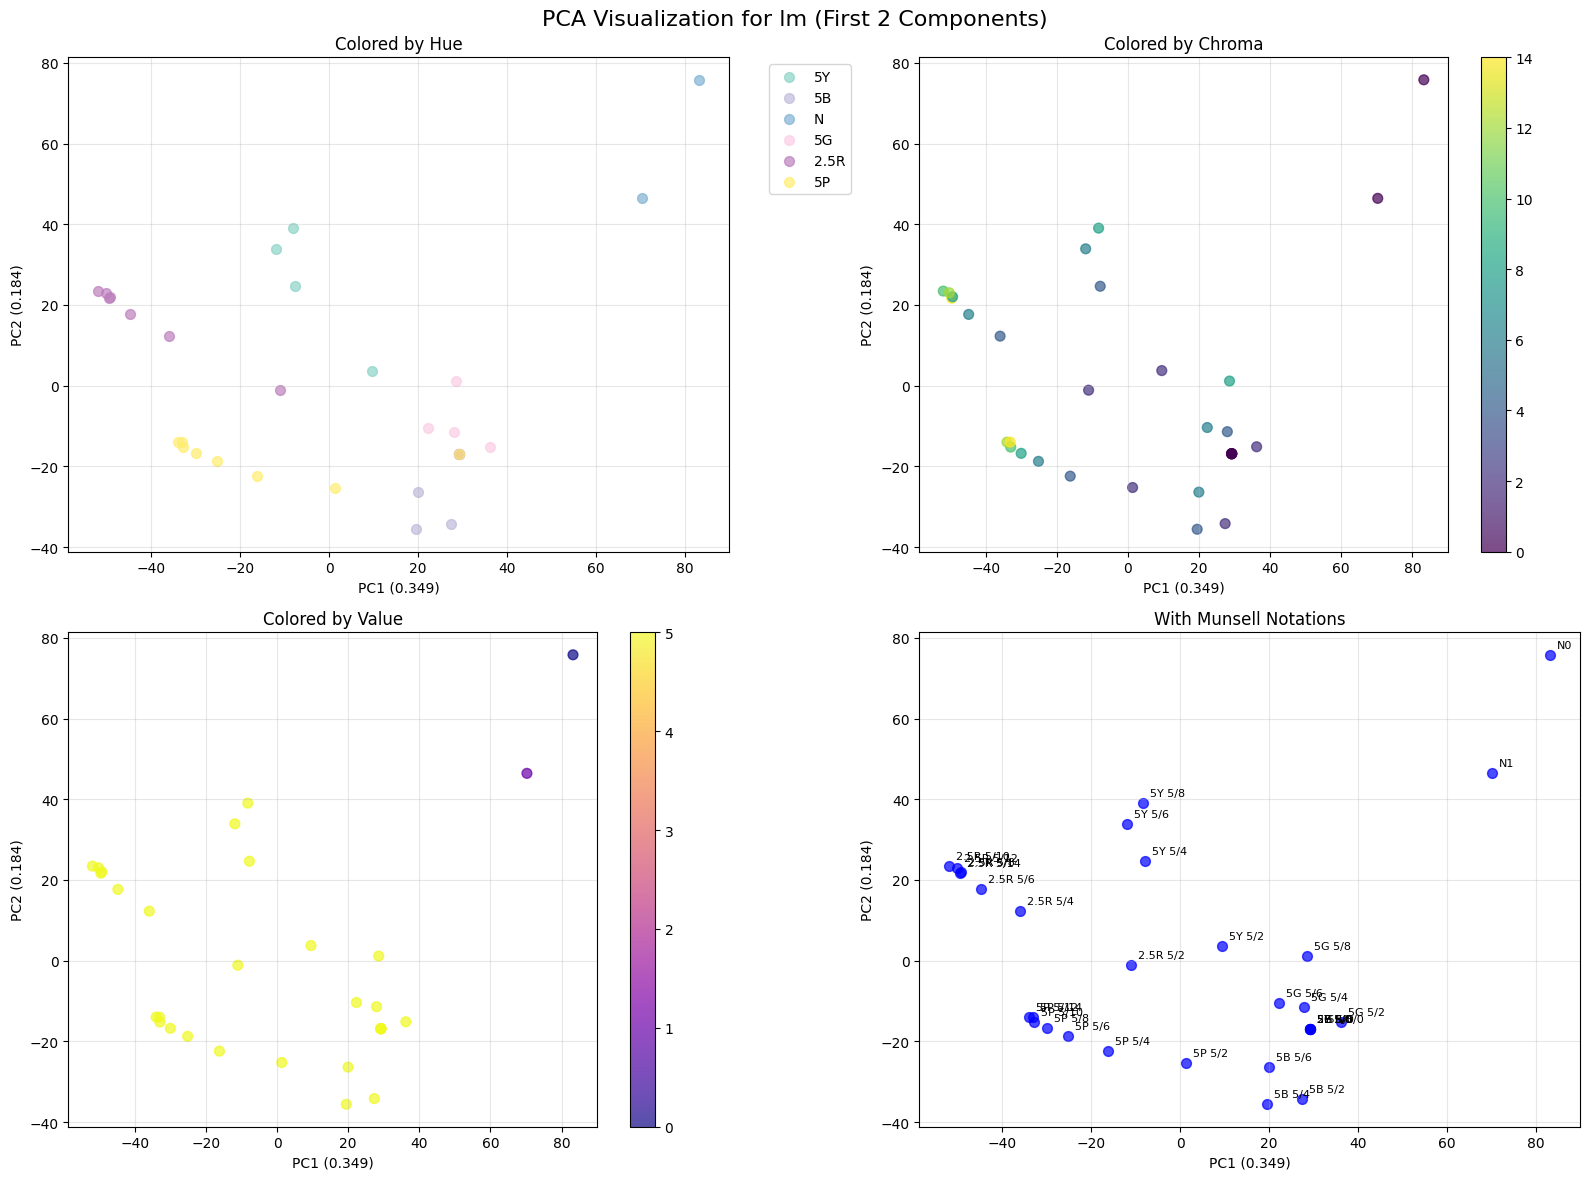

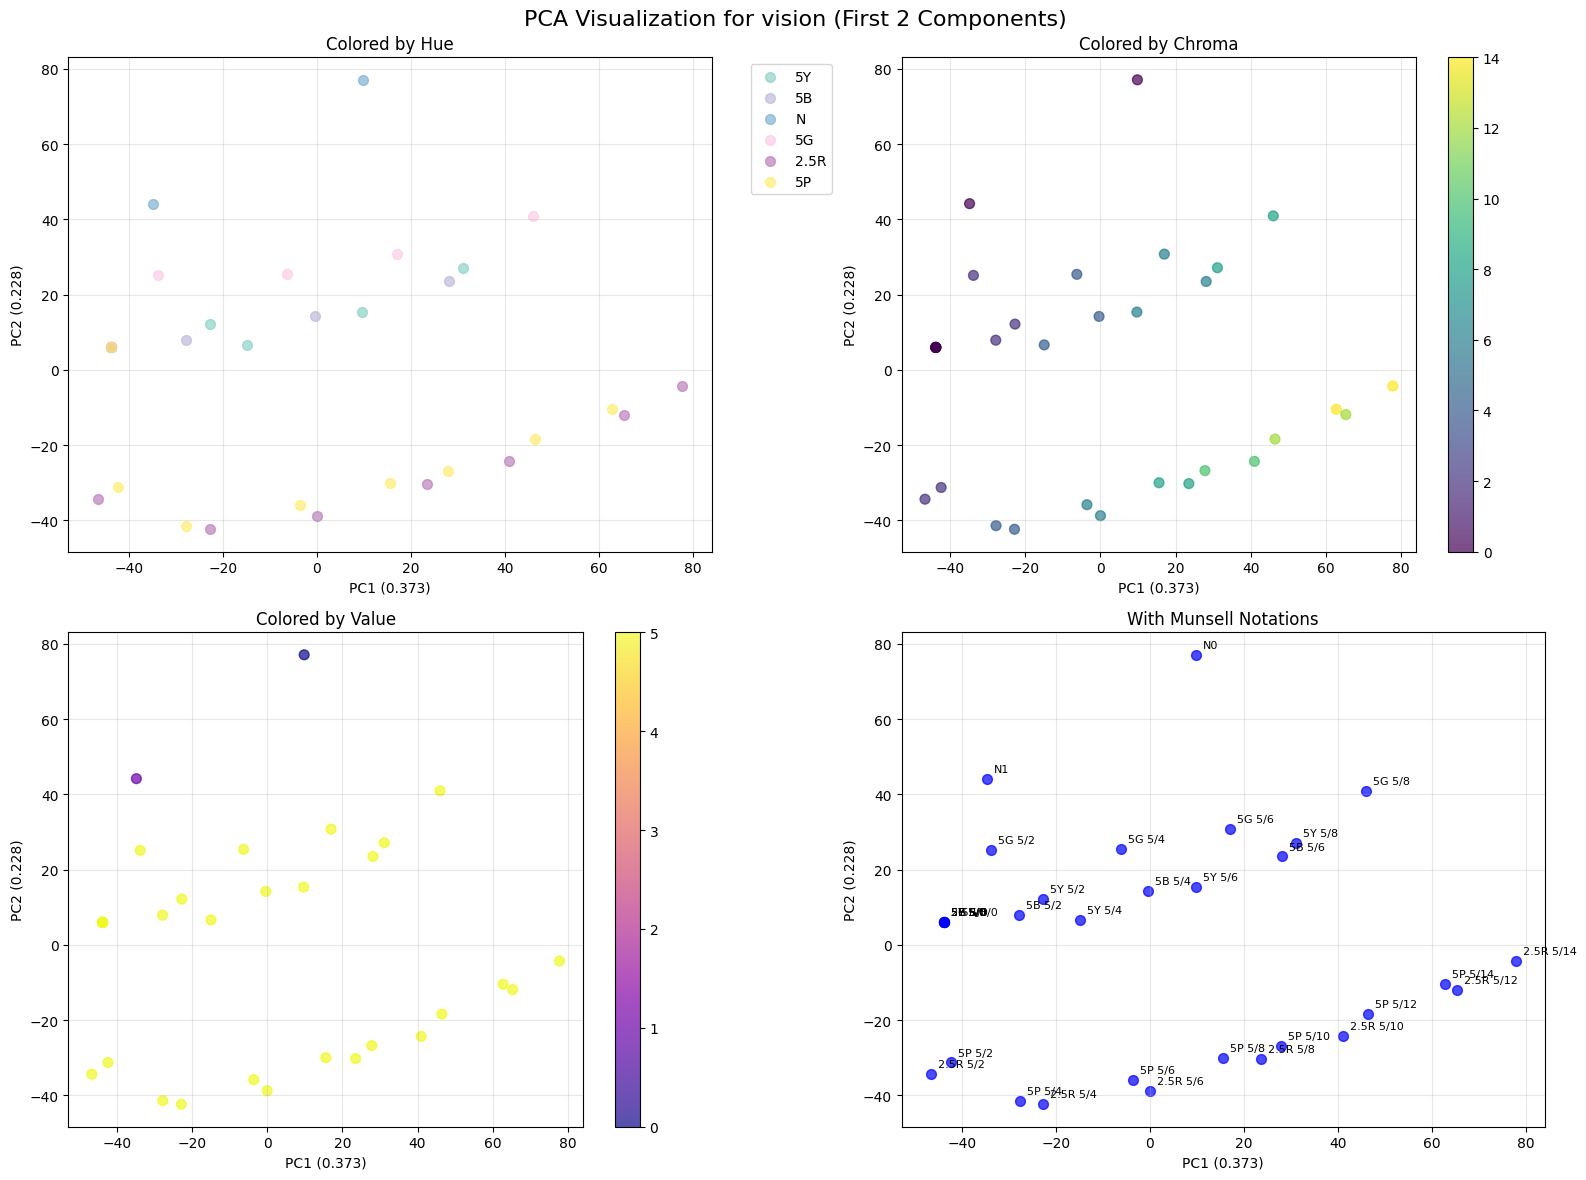

In [16]:
# Visualize PCA results in 2D
def plot_pca_2d(pca_results, color_metadata, embedding_name):
    """Plot first 2 PCA components colored by color attributes"""
    if embedding_name not in pca_results or pca_results[embedding_name] is None:
        return
    
    pca_result = pca_results[embedding_name]['pca_result']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'PCA Visualization for {embedding_name} (First 2 Components)', fontsize=16)
    
    # Extract color information
    hues = [meta.get('H', 'Unknown') for meta in color_metadata]
    chromas = [meta.get('C', 0) for meta in color_metadata]
    values = [meta.get('V', 0) for meta in color_metadata]
    notations = [meta.get('notation', 'Unknown') for meta in color_metadata]
    
    # Plot 1: Colored by Hue
    unique_hues = list(set(hues))
    hue_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_hues)))
    hue_color_map = {hue: hue_colors[i] for i, hue in enumerate(unique_hues)}
    
    for hue in unique_hues:
        mask = [h == hue for h in hues]
        axes[0,0].scatter(pca_result[mask, 0], pca_result[mask, 1], 
                         c=[hue_color_map[hue]], label=hue, alpha=0.7, s=50)
    axes[0,0].set_title('Colored by Hue')
    axes[0,0].set_xlabel(f'PC1 ({pca_results[embedding_name]["explained_variance_ratio"][0]:.3f})')
    axes[0,0].set_ylabel(f'PC2 ({pca_results[embedding_name]["explained_variance_ratio"][1]:.3f})')
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Colored by Chroma
    scatter = axes[0,1].scatter(pca_result[:, 0], pca_result[:, 1], 
                               c=chromas, cmap='viridis', alpha=0.7, s=50)
    axes[0,1].set_title('Colored by Chroma')
    axes[0,1].set_xlabel(f'PC1 ({pca_results[embedding_name]["explained_variance_ratio"][0]:.3f})')
    axes[0,1].set_ylabel(f'PC2 ({pca_results[embedding_name]["explained_variance_ratio"][1]:.3f})')
    plt.colorbar(scatter, ax=axes[0,1])
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Colored by Value
    scatter = axes[1,0].scatter(pca_result[:, 0], pca_result[:, 1], 
                               c=values, cmap='plasma', alpha=0.7, s=50)
    axes[1,0].set_title('Colored by Value')
    axes[1,0].set_xlabel(f'PC1 ({pca_results[embedding_name]["explained_variance_ratio"][0]:.3f})')
    axes[1,0].set_ylabel(f'PC2 ({pca_results[embedding_name]["explained_variance_ratio"][1]:.3f})')
    plt.colorbar(scatter, ax=axes[1,0])
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: All points with notation labels
    axes[1,1].scatter(pca_result[:, 0], pca_result[:, 1], 
                     c='blue', alpha=0.7, s=50)
    # Add notation labels
    for i, notation in enumerate(notations):
        axes[1,1].annotate(notation, (pca_result[i, 0], pca_result[i, 1]), 
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[1,1].set_title('With Munsell Notations')
    axes[1,1].set_xlabel(f'PC1 ({pca_results[embedding_name]["explained_variance_ratio"][0]:.3f})')
    axes[1,1].set_ylabel(f'PC2 ({pca_results[embedding_name]["explained_variance_ratio"][1]:.3f})')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot PCA 2D results for all embedding types
for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in pca_results:
        color_meta = {'lm': lm_color_meta, 'vision': vision_color_meta, 'lens': lens_color_meta}[emb_type]
        plot_pca_2d(pca_results, color_meta, emb_type)


In [17]:
# Summary and comparison of results
def print_analysis_summary(pca_results, tsne_results):
    """Print summary of analysis results"""
    print("=" * 80)
    print("EMBEDDING ANALYSIS SUMMARY")
    print("=" * 80)
    
    for emb_type in ['lm', 'vision', 'lens']:
        emb_name = {'lm': 'LM Pooled Mean', 'vision': 'Vision Pooled Mean', 'lens': 'Visual Token Lens'}[emb_type]
        
        print(f"\n{emb_name.upper()}:")
        print("-" * 40)
        
        if emb_type in pca_results and pca_results[emb_type] is not None:
            pca = pca_results[emb_type]
            print(f"PCA Results:")
            print(f"  - Components for 95% variance: {pca['n_components_95']}")
            print(f"  - Components for 99% variance: {pca['n_components_99']}")
            print(f"  - First 2 components explain: {pca['cumulative_variance'][1]:.3f} of variance")
            print(f"  - First 5 components explain: {pca['cumulative_variance'][4]:.3f} of variance")
        else:
            print("  - PCA: No data available")
            
        if emb_type in tsne_results and tsne_results[emb_type] is not None:
            tsne = tsne_results[emb_type]
            print(f"t-SNE Results:")
            print(f"  - Final KL divergence: {tsne['tsne_model'].kl_divergence_:.3f}")
            print(f"  - Perplexity used: {tsne['tsne_model'].perplexity}")
        else:
            print("  - t-SNE: No data available")

print_analysis_summary(pca_results, tsne_results)

# Additional analysis: Compare embedding types
print("\n" + "=" * 80)
print("COMPARATIVE ANALYSIS")
print("=" * 80)

# Compare PCA effectiveness across embedding types
print("\nPCA Effectiveness Comparison:")
print("Embedding Type | 95% Var Components | 99% Var Components | PC1+PC2 Var")
print("-" * 70)

for emb_type in ['lm', 'vision', 'lens']:
    emb_name = {'lm': 'LM Pooled Mean', 'vision': 'Vision Pooled Mean', 'lens': 'Visual Token Lens'}[emb_type]
    if emb_type in pca_results and pca_results[emb_type] is not None:
        pca = pca_results[emb_type]
        pc1_pc2_var = pca['cumulative_variance'][1]
        print(f"{emb_name:15} | {pca['n_components_95']:18} | {pca['n_components_99']:18} | {pc1_pc2_var:.3f}")
    else:
        print(f"{emb_name:15} | {'N/A':18} | {'N/A':18} | N/A")


EMBEDDING ANALYSIS SUMMARY

LM POOLED MEAN:
----------------------------------------
PCA Results:
  - Components for 95% variance: 7
  - Components for 99% variance: 11
  - First 2 components explain: 0.533 of variance
  - First 5 components explain: 0.905 of variance
t-SNE Results:
  - Final KL divergence: -0.013
  - Perplexity used: 30

VISION POOLED MEAN:
----------------------------------------
PCA Results:
  - Components for 95% variance: 7
  - Components for 99% variance: 10
  - First 2 components explain: 0.601 of variance
  - First 5 components explain: 0.913 of variance
t-SNE Results:
  - Final KL divergence: -0.021
  - Perplexity used: 30

VISUAL TOKEN LENS:
----------------------------------------
  - PCA: No data available
  - t-SNE: No data available

COMPARATIVE ANALYSIS

PCA Effectiveness Comparison:
Embedding Type | 95% Var Components | 99% Var Components | PC1+PC2 Var
----------------------------------------------------------------------
LM Pooled Mean  |              

In [18]:
# Additional analysis: Chroma progression analysis
def analyze_chroma_progression(pca_results, tsne_results, color_metadata, embedding_name):
    """Analyze how chroma progression is captured in embeddings"""
    if embedding_name not in pca_results or pca_results[embedding_name] is None:
        return
    
    print(f"\n=== Chroma Progression Analysis for {embedding_name} ===")
    
    # Group by hue and analyze chroma progression
    hue_groups = {}
    for i, meta in enumerate(color_metadata):
        hue = meta.get('H', 'Unknown')
        chroma = meta.get('C', 0)
        if hue not in hue_groups:
            hue_groups[hue] = []
        hue_groups[hue].append((i, chroma, meta.get('notation', 'Unknown')))
    
    # Sort each hue group by chroma
    for hue in hue_groups:
        hue_groups[hue].sort(key=lambda x: x[1])
    
    # Analyze PCA progression
    pca_result = pca_results[embedding_name]['pca_result']
    print("\nPCA Chroma Progression (PC1 vs Chroma):")
    for hue, samples in hue_groups.items():
        if len(samples) > 1:  # Only analyze hues with multiple chroma levels
            indices = [s[0] for s in samples]
            chromas = [s[1] for s in samples]
            pc1_values = pca_result[indices, 0]
            
            # Calculate correlation between PC1 and chroma
            correlation = np.corrcoef(pc1_values, chromas)[0, 1]
            print(f"  {hue}: Correlation = {correlation:.3f}")
            print(f"    Chroma progression: {chromas}")
            print(f"    PC1 progression: {pc1_values}")
    
    # Analyze t-SNE progression
    if embedding_name in tsne_results and tsne_results[embedding_name] is not None:
        tsne_result = tsne_results[embedding_name]['tsne_result']
        print("\nt-SNE Chroma Progression:")
        for hue, samples in hue_groups.items():
            if len(samples) > 1:
                indices = [s[0] for s in samples]
                chromas = [s[1] for s in samples]
                tsne_x = tsne_result[indices, 0]
                tsne_y = tsne_result[indices, 1]
                
                # Calculate distance progression
                distances = []
                for i in range(len(indices) - 1):
                    dist = np.sqrt((tsne_x[i+1] - tsne_x[i])**2 + (tsne_y[i+1] - tsne_y[i])**2)
                    distances.append(dist)
                
                print(f"  {hue}: Average step distance = {np.mean(distances):.3f}")
                print(f"    Chroma progression: {chromas}")
                print(f"    Step distances: {distances}")

# Perform chroma progression analysis for all embedding types
for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in pca_results:
        color_meta = {'lm': lm_color_meta, 'vision': vision_color_meta, 'lens': lens_color_meta}[emb_type]
        analyze_chroma_progression(pca_results, tsne_results, color_meta, emb_type)



=== Chroma Progression Analysis for lm ===

PCA Chroma Progression (PC1 vs Chroma):
  N: Correlation = nan
    Chroma progression: [0, 0]
    PC1 progression: [83.211945 70.257645]
  2.5R: Correlation = -0.818
    Chroma progression: [0, 2, 4, 6, 8, 10, 12, 14]
    PC1 progression: [ 29.183798 -11.052212 -35.94165  -44.780582 -49.29684  -51.926056
 -50.211964 -49.550575]
  5Y: Correlation = -0.883
    Chroma progression: [0, 2, 4, 6, 8]
    PC1 progression: [ 29.183804   9.528267  -7.785095 -11.875396  -8.235942]
  5B: Correlation = -0.919
    Chroma progression: [0, 2, 4, 6]
    PC1 progression: [29.183792 27.347456 19.47928  19.951023]
  5G: Correlation = -0.483
    Chroma progression: [0, 2, 4, 6, 8]
    PC1 progression: [29.183792 36.203514 27.962788 22.31965  28.576286]
  5P: Correlation = -0.870
    Chroma progression: [0, 2, 4, 6, 8, 10, 12, 14]
    PC1 progression: [ 29.183798    1.3218743 -16.219816  -25.14568   -30.011349  -32.947857
 -34.02474   -33.07298  ]

t-SNE Chroma P